In [ ]:
import numpy as np
import pandas as pd
import os
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input


- Connection with Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/project/dataset')

- Reading the Csv File

In [ ]:
path = 'GroundTruth.csv'
train = pd.read_csv(path)
train.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


- Set the dataframe to make it suitable for classification
- Image path and label column

In [ ]:
import pandas as pd

label_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

results = []

for index, row in train.iterrows():
    labels = row[label_columns][row[label_columns] == 1].index.tolist()
    for label in labels:
        results.append({'image_path': row['image'], 'label': label})

In [ ]:
data = pd.DataFrame(results)

In [ ]:
data['image_path'] = data['image_path'].apply(lambda x: os.path.join(x+'.jpg'))

In [ ]:
data.head()

,image_path,label
0,ISIC_0024306.jpg,NV
1,ISIC_0024307.jpg,NV
2,ISIC_0024308.jpg,NV
3,ISIC_0024309.jpg,NV
4,ISIC_0024310.jpg,MEL


- Checking the number of data in each cancer class

In [ ]:
data['label'].value_counts()

,count
label,
NV,6705
MEL,1113
BKL,1099
BCC,514
AKIEC,327
VASC,142
DF,115


In [ ]:
data = data[~data['label'].isin(['AKIEC', 'VASC', 'DF'])]

data['label'].value_counts()

,count
label,
NV,6705
MEL,1113
BKL,1099
BCC,514


- DataGenerator class will load augmented images and corresponding labels for training. also spliting the data into training and testing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.20
)

train_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/content/drive/MyDrive/project/dataset/images',
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/content/drive/MyDrive/project/dataset/images',
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)


Found 7545 validated image filenames belonging to 4 classes.
Found 1886 validated image filenames belonging to 4 classes.


In [ ]:
x_batch, y_batch = next(train_generator)

print('Input shape:', x_batch.shape)
print('Output shape:', y_batch.shape)

Input shape: (16, 224, 224, 3)
Output shape: (16, 4)


## **Vgg16**
- Pretrained Vgg Model loading and compiling for the training
- Set optimizer, loss function and matrix to see the performance

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)

predictions = Dense(4, activation='softmax')(x)

for layer in base_model.layers[:-6]:
    layer.trainable = False
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 15,043,524 (57.39 MB)

 Trainable params: 9,768,068 (37.26 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

- Model training on our Data

In [ ]:
history=model.fit(train_generator,
          validation_data=validation_generator,
            verbose=1,
          epochs=15)
model.save('vgg_classification_model.h5')

Epoch 1/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 2041s 4s/step - accuracy: 0.6900 - loss: 0.9013 - precision: 0.7605 - recall: 0.5999 - val_accuracy: 0.7291 - val_loss: 0.6725 - val_precision: 0.8311 - val_recall: 0.6782
Epoch 2/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 173s 362ms/step - accuracy: 0.7151 - loss: 0.7795 - precision: 0.8352 - recall: 0.6224 - val_accuracy: 0.7354 - val_loss: 0.6510 - val_precision: 0.8842 - val_recall: 0.6559
Epoch 3/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 170s 356ms/step - accuracy: 0.7131 - loss: 0.7408 - precision: 0.8435 - recall: 0.6185 - val_accuracy: 0.7349 - val_loss: 0.6995 - val_precision: 0.8169 - val_recall: 0.7025
Epoch 4/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 170s 356ms/step - accuracy: 0.7174 - loss: 0.7136 - precision: 0.8509 - recall: 0.6253 - val_accuracy: 0.7328 - val_loss: 0.6229 - val_precision: 0.8871 - val_recall: 0.6458
Epoch 5/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 171s 358ms/step - accuracy: 0.7374 - loss: 0.6520 - precision: 0.8582 - recall: 0.6364 - val_accuracy: 0.7

In [ ]:
history.history

{'accuracy': [0.7053678035736084,
  0.7119947075843811,
  0.7147780060768127,
  0.7225977182388306,
  0.7362491488456726,
  0.7453942894935608,
  0.7496355175971985,
  0.7595759034156799,
  0.7578529119491577,
  0.7574552893638611,
  0.7703114748001099,
  0.7679257988929749,
  0.7765407562255859,
  0.7749503254890442,
  0.7806494235992432],
 'loss': [0.8205991387367249,
  0.7573597431182861,
  0.7335732579231262,
  0.696001410484314,
  0.6593796610832214,
  0.6392694115638733,
  0.6301850080490112,
  0.6114148497581482,
  0.6076751947402954,
  0.6028619408607483,
  0.5814284086227417,
  0.5818363428115845,
  0.5696778297424316,
  0.5701175928115845,
  0.5657310485839844],
 'precision': [0.7959253787994385,
  0.8382167816162109,
  0.8510367274284363,
  0.8581585884094238,
  0.8542488217353821,
  0.8538408279418945,
  0.8548191785812378,
  0.8509348034858704,
  0.8524920344352722,
  0.8556104302406311,
  0.8553198575973511,
  0.8489540219306946,
  0.8501384854316711,
  0.8448579907417297

#### Model Evaluation
- Displaying training and validation loss, accuracy, recall and precision
- Also the Confusion Matrix and classification report

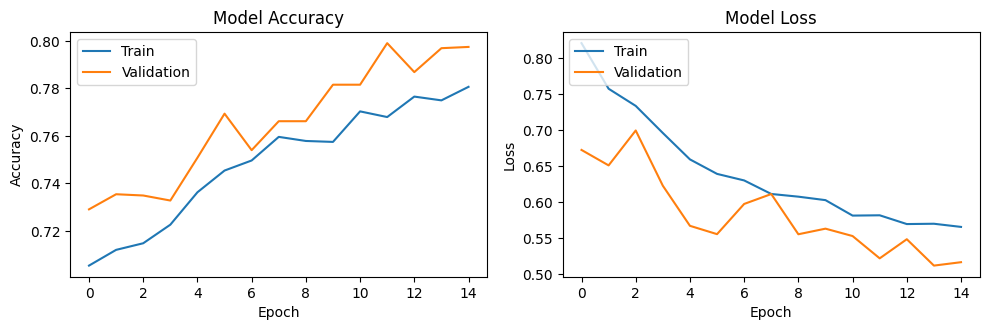

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot for loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

predictions = model.predict(validation_generator)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(conf_matrix)



118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 296ms/step
Confusion Matrix:
[[  77   13    0    9]
 [  37   87   14   93]
 [   8   31   24  110]
 [  22   35   10 1316]]


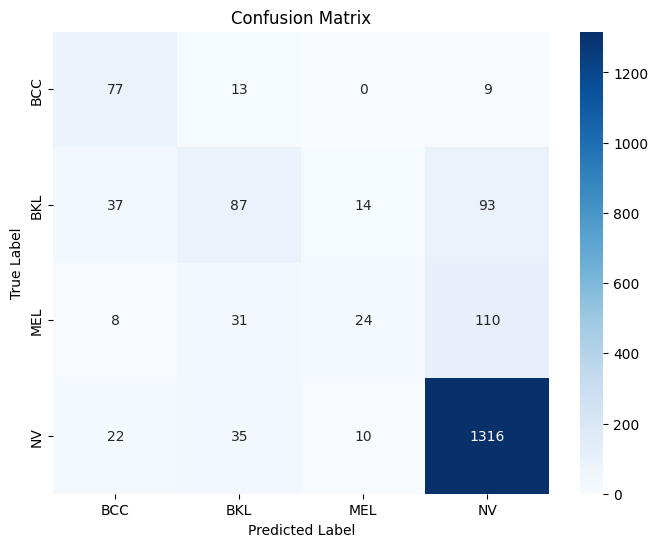

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
class_names = list(validation_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

         BCC       0.53      0.78      0.63        99
         BKL       0.52      0.38      0.44       231
         MEL       0.50      0.14      0.22       173
          NV       0.86      0.95      0.90      1383

    accuracy                           0.80      1886
   macro avg       0.61      0.56      0.55      1886
weighted avg       0.77      0.80      0.77      1886



#### Model Testing
- Testing the model on an image and see the prediction

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from keras.models import load_model
from PIL import Image

loaded_model = load_model('vgg_classification_model.h5')


img_path = 'images/ISIC_0024321.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

predictions = loaded_model.predict(img_array)

predicted_class_index = np.argmax(predictions[0])

class_labels = {0: 'bcc', 1: 'bkl', 2: 'mel',3: 'nv'}
predicted_class_label = class_labels[predicted_class_index]
print("Predicted Class:", predicted_class_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: nv


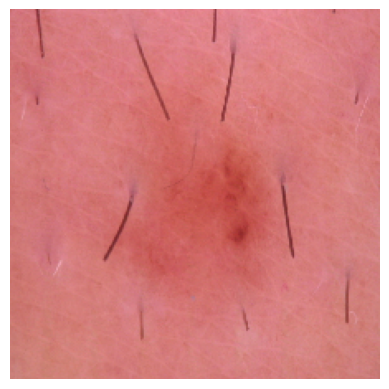

In [ ]:
resized_img = img.resize((224, 224))
plt.imshow(resized_img)
plt.axis('off')
plt.show()

In [7]:
# prompt: make a graph characterising the resultsof classes and best class

import matplotlib.pyplot as plt

# Assuming 'history' is your training history object
# and 'class_names' is the list of class names

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Assuming 'conf_matrix' is your confusion matrix from sklearn.metrics.confusion_matrix
# and 'class_names' is a list of class names

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
# prompt: the above code ddnt give a result

from tensorflow.keras.models import load_model
# ... (Your existing code) ...